## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 10.2 and accuracy of 0.094
Iteration 100: with minibatch training loss = 0.97 and accuracy of 0.27
Iteration 200: with minibatch training loss = 0.764 and accuracy of 0.3
Iteration 300: with minibatch training loss = 0.54 and accuracy of 0.33
Iteration 400: with minibatch training loss = 0.546 and accuracy of 0.34
Iteration 500: with minibatch training loss = 0.592 and accuracy of 0.36
Iteration 600: with minibatch training loss = 0.54 and accuracy of 0.34
Iteration 700: with minibatch training loss = 0.433 and accuracy of 0.38
Epoch 1, Overall loss = 0.764 and accuracy of 0.307


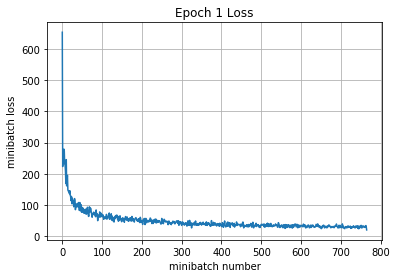

Validation
Epoch 1, Overall loss = 0.434 and accuracy of 0.363


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += float(np.sum(corr))
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
#                 print (float(np.sum(corr))/actual_batch_size)
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,float(np.sum(corr))/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [5]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    pass
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    beta1  = tf.get_variable("beta1",shape = [26,26,32]) # (32-7+1)/1 = 26
    gamma1 = tf.get_variable("gamma",shape = [26,26,32])
    Wfc1 = tf.get_variable("Wfc1",shape=[5408,1024])
    bfc1 = tf.get_variable("bfc1",shape=[1024])
    Wfc2 = tf.get_variable("Wfc2",shape=[1024,10])
    bfc2 = tf.get_variable("bfc2",shape=[10])    
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h2 = tf.layers.batch_normalization(h1,training=is_training)
    h3 = tf.nn.max_pool(h2, ksize=[1, 2, 2, 1], strides= [1, 2, 2, 1], padding = 'SAME')
    h4 = tf.matmul(tf.reshape(h3, [-1, 13*13*32]), Wfc1) + bfc1
    h5 = tf.nn.relu(h4)
    y_out = tf.matmul(h5, Wfc2) + bfc2
    return y_out

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

100 loops, best of 3: 5.04 ms per loop
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [7]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

100 loops, best of 3: 5.04 ms per loop


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [8]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None
pass
total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
# total_loss= tf.losses.softmax_cross_entropy(tf.one_hot(y,10),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3) 

In [9]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.29 and accuracy of 0.031
Iteration 100: with minibatch training loss = 2.14 and accuracy of 0.39
Iteration 200: with minibatch training loss = 1.97 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.49 and accuracy of 0.53
Iteration 400: with minibatch training loss = 1.36 and accuracy of 0.55
Iteration 500: with minibatch training loss = 1.33 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.33 and accuracy of 0.61
Iteration 700: with minibatch training loss = 1.28 and accuracy of 0.52
Epoch 1, Overall loss = 1.67 and accuracy of 0.454


(1.6677968434703594, 0.45424489795918366)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [11]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.29 and accuracy of 0.55


(1.292858772277832, 0.55)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [17]:
# Feel free to play with this cell
DROPOUT_RATE = 0.5
init = tf.contrib.layers.xavier_initializer()
def res_block(input_layer, i):
    with tf.variable_scope("res_block"+str(i)):
        res_conv1 = tf.layers.conv2d(input_layer, 96, kernel_size=3, strides=1, kernel_initializer=init)
        res_bn1 = tf.layers.batch_normalization(res_conv1,training=is_training)
        res_conv2 = tf.layers.conv2d(tf.nn.relu(res_bn1), 96, kernel_size=3, strides=1, kernel_initializer=init)
        res_bn2 = tf.layers.batch_normalization(res_conv2,training=is_training)
        res_out = tf.nn.relu(input_layer +  res_bn2)
    return res_out
        
def my_model(X,y,is_training):
    pass
    conv1 = tf.layers.conv2d(X, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn1 = tf.layers.batch_normalization(conv1,training=is_training)
    conv2 = tf.layers.conv2d(bn1, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn2 = tf.layers.batch_normalization(conv2,training=is_training)
    pool1 = tf.layers.max_pooling2d(bn2, pool_size=2, strides=2)
    dp1 = tf.layers.dropout(pool1, rate=DROPOUT_RATE, training=is_training)
    
    conv3 = tf.layers.conv2d(dp1, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn3 = tf.layers.batch_normalization(conv3,training=is_training)
    conv4 = tf.layers.conv2d(bn3, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn4 = tf.layers.batch_normalization(conv4,training=is_training)
    pool2 = tf.layers.max_pooling2d(bn4, pool_size=2, strides=2)
    dp2 = tf.layers.dropout(pool2, rate=DROPOUT_RATE, training=is_training)
    
#     res_conv1 = tf.layers.conv2d(dp2, 96, kernel_size=3, strides=1)
#     res_bn1 = tf.layers.batch_normalization(res_conv1,training=is_training)
#     res_conv2 = tf.layers.conv2d(tf.nn.relu(res_bn1), 96, kernel_size=3, strides=1)
#     res_bn2 = tf.layers.batch_normalization(res_conv2,training=is_training)
#     res_out = tf.nn.relu(dp2 +  res_bn2)
    res_input = dp2
    for i in range(5):
        res_out = res_block(res_input, i)
    
    flatten = tf.reshape(res_out, [-1, 5*5*96])
    fc1 = tf.layers.dense(flatten, 384, activation=tf.nn.relu)
    fc_bn1 = tf.layers.batch_normalization(fc1,center=False,scale=False,training=is_training)
    fc_dp1 = tf.layers.dropout(fc_bn1, rate=DROPOUT_RATE, training=is_training)
    fc2 = tf.layers.dense(fc_dp1, 192, activation=tf.nn.relu)
    fc_bn2 = tf.layers.batch_normalization(fc2,center=False,scale=False,training=is_training)
    fc_dp2 = tf.layers.dropout(fc_bn2, rate=DROPOUT_RATE, training=is_training)
    fc3 = tf.layers.dense(fc_dp2, 10, activation=tf.nn.relu)
    fc_bn3 = tf.layers.batch_normalization(fc3,center=False,scale=False,training=is_training)
    return fc3
    
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = None
optimizer = None

total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
# total_loss= tf.losses.softmax_cross_entropy(tf.one_hot(y,10),y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=5e-5)

pass

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.79 and accuracy of 0.2
Iteration 100: with minibatch training loss = 2.92 and accuracy of 0.062
Iteration 200: with minibatch training loss = 2.91 and accuracy of 0.14
Iteration 300: with minibatch training loss = 2.93 and accuracy of 0.14
Iteration 400: with minibatch training loss = 2.65 and accuracy of 0.11
Iteration 500: with minibatch training loss = 2.87 and accuracy of 0.11
Iteration 600: with minibatch training loss = 2.42 and accuracy of 0.25
Iteration 700: with minibatch training loss = 2.46 and accuracy of 0.22
Epoch 1, Overall loss = 2.7 and accuracy of 0.162


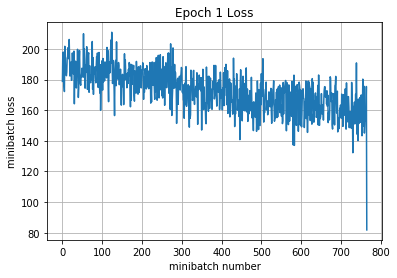

Iteration 800: with minibatch training loss = 2.61 and accuracy of 0.14
Iteration 900: with minibatch training loss = 2.46 and accuracy of 0.27
Iteration 1000: with minibatch training loss = 2.33 and accuracy of 0.22
Iteration 1100: with minibatch training loss = 2.23 and accuracy of 0.36
Iteration 1200: with minibatch training loss = 2.22 and accuracy of 0.28
Iteration 1300: with minibatch training loss = 2.07 and accuracy of 0.33
Iteration 1400: with minibatch training loss = 1.83 and accuracy of 0.41
Iteration 1500: with minibatch training loss = 2.31 and accuracy of 0.27
Epoch 2, Overall loss = 2.32 and accuracy of 0.247


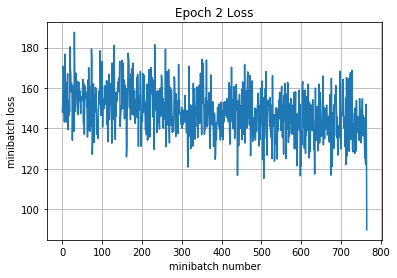

Iteration 1600: with minibatch training loss = 2.43 and accuracy of 0.17
Iteration 1700: with minibatch training loss = 2.25 and accuracy of 0.2
Iteration 1800: with minibatch training loss = 2.05 and accuracy of 0.23
Iteration 1900: with minibatch training loss = 2.03 and accuracy of 0.27
Iteration 2000: with minibatch training loss = 1.79 and accuracy of 0.38
Iteration 2100: with minibatch training loss = 2.04 and accuracy of 0.3
Iteration 2200: with minibatch training loss = 1.91 and accuracy of 0.27
Epoch 3, Overall loss = 2.11 and accuracy of 0.297


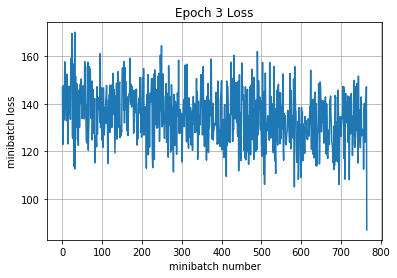

Iteration 2300: with minibatch training loss = 1.83 and accuracy of 0.34
Iteration 2400: with minibatch training loss = 1.78 and accuracy of 0.41
Iteration 2500: with minibatch training loss = 2.17 and accuracy of 0.28
Iteration 2600: with minibatch training loss = 2.03 and accuracy of 0.19
Iteration 2700: with minibatch training loss = 1.7 and accuracy of 0.41
Iteration 2800: with minibatch training loss = 1.9 and accuracy of 0.34
Iteration 2900: with minibatch training loss = 2.07 and accuracy of 0.23
Iteration 3000: with minibatch training loss = 1.72 and accuracy of 0.42
Epoch 4, Overall loss = 1.95 and accuracy of 0.335


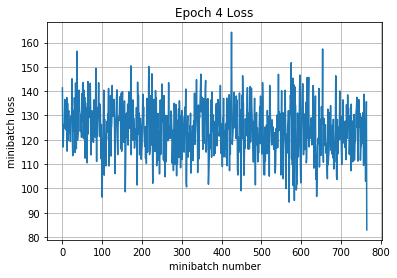

Iteration 3100: with minibatch training loss = 1.95 and accuracy of 0.34
Iteration 3200: with minibatch training loss = 1.96 and accuracy of 0.38
Iteration 3300: with minibatch training loss = 2.07 and accuracy of 0.3
Iteration 3400: with minibatch training loss = 1.89 and accuracy of 0.36
Iteration 3500: with minibatch training loss = 1.74 and accuracy of 0.41
Iteration 3600: with minibatch training loss = 1.55 and accuracy of 0.5
Iteration 3700: with minibatch training loss = 1.89 and accuracy of 0.36
Iteration 3800: with minibatch training loss = 1.78 and accuracy of 0.36
Epoch 5, Overall loss = 1.83 and accuracy of 0.373


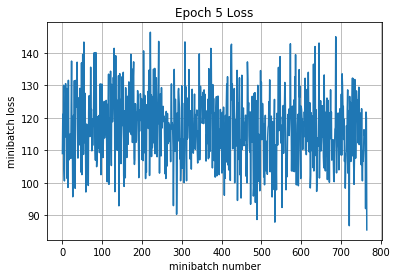

Iteration 3900: with minibatch training loss = 1.94 and accuracy of 0.31
Iteration 4000: with minibatch training loss = 1.66 and accuracy of 0.36
Iteration 4100: with minibatch training loss = 1.75 and accuracy of 0.39
Iteration 4200: with minibatch training loss = 1.73 and accuracy of 0.36
Iteration 4300: with minibatch training loss = 1.54 and accuracy of 0.36
Iteration 4400: with minibatch training loss = 1.75 and accuracy of 0.44
Iteration 4500: with minibatch training loss = 1.57 and accuracy of 0.44
Epoch 6, Overall loss = 1.73 and accuracy of 0.402


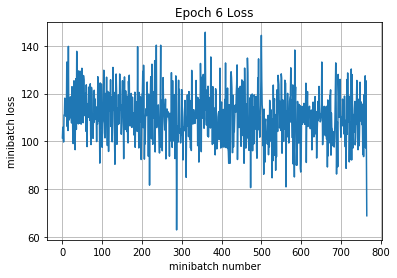

Iteration 4600: with minibatch training loss = 1.7 and accuracy of 0.36
Iteration 4700: with minibatch training loss = 1.55 and accuracy of 0.52
Iteration 4800: with minibatch training loss = 2 and accuracy of 0.41
Iteration 4900: with minibatch training loss = 1.67 and accuracy of 0.45
Iteration 5000: with minibatch training loss = 1.57 and accuracy of 0.45
Iteration 5100: with minibatch training loss = 1.66 and accuracy of 0.39
Iteration 5200: with minibatch training loss = 1.66 and accuracy of 0.39
Iteration 5300: with minibatch training loss = 1.83 and accuracy of 0.38
Epoch 7, Overall loss = 1.65 and accuracy of 0.426


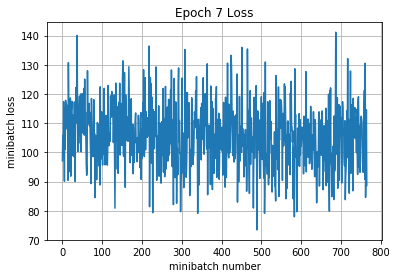

Iteration 5400: with minibatch training loss = 1.66 and accuracy of 0.47
Iteration 5500: with minibatch training loss = 1.45 and accuracy of 0.48
Iteration 5600: with minibatch training loss = 1.52 and accuracy of 0.44
Iteration 5700: with minibatch training loss = 1.49 and accuracy of 0.53
Iteration 5800: with minibatch training loss = 1.91 and accuracy of 0.42
Iteration 5900: with minibatch training loss = 1.44 and accuracy of 0.36
Iteration 6000: with minibatch training loss = 1.47 and accuracy of 0.47
Iteration 6100: with minibatch training loss = 1.45 and accuracy of 0.5
Epoch 8, Overall loss = 1.57 and accuracy of 0.454


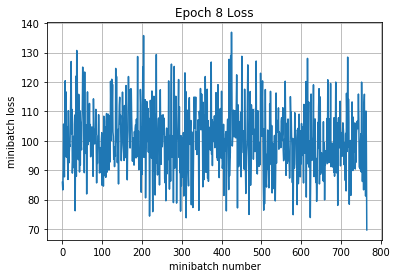

Iteration 6200: with minibatch training loss = 1.39 and accuracy of 0.53
Iteration 6300: with minibatch training loss = 1.88 and accuracy of 0.41
Iteration 6400: with minibatch training loss = 1.36 and accuracy of 0.53
Iteration 6500: with minibatch training loss = 1.32 and accuracy of 0.55
Iteration 6600: with minibatch training loss = 1.62 and accuracy of 0.48
Iteration 6700: with minibatch training loss = 1.64 and accuracy of 0.39
Iteration 6800: with minibatch training loss = 1.72 and accuracy of 0.39
Epoch 9, Overall loss = 1.49 and accuracy of 0.48


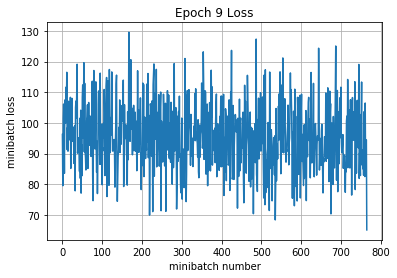

Iteration 6900: with minibatch training loss = 1.55 and accuracy of 0.42
Iteration 7000: with minibatch training loss = 1.49 and accuracy of 0.39
Iteration 7100: with minibatch training loss = 1.47 and accuracy of 0.47
Iteration 7200: with minibatch training loss = 1.23 and accuracy of 0.61
Iteration 7300: with minibatch training loss = 1.24 and accuracy of 0.53
Iteration 7400: with minibatch training loss = 1.06 and accuracy of 0.7
Iteration 7500: with minibatch training loss = 1.34 and accuracy of 0.53
Iteration 7600: with minibatch training loss = 1.38 and accuracy of 0.52
Epoch 10, Overall loss = 1.42 and accuracy of 0.503


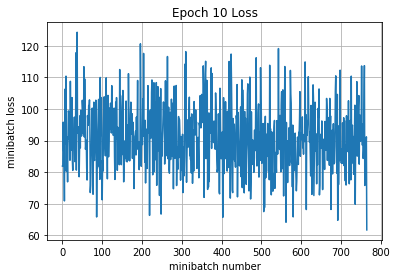

Iteration 7700: with minibatch training loss = 1.44 and accuracy of 0.53
Iteration 7800: with minibatch training loss = 1.27 and accuracy of 0.59
Iteration 7900: with minibatch training loss = 1.43 and accuracy of 0.52
Iteration 8000: with minibatch training loss = 1.42 and accuracy of 0.48
Iteration 8100: with minibatch training loss = 1.17 and accuracy of 0.58
Iteration 8200: with minibatch training loss = 1.35 and accuracy of 0.56
Iteration 8300: with minibatch training loss = 1.2 and accuracy of 0.58
Iteration 8400: with minibatch training loss = 1.63 and accuracy of 0.45
Epoch 11, Overall loss = 1.35 and accuracy of 0.532


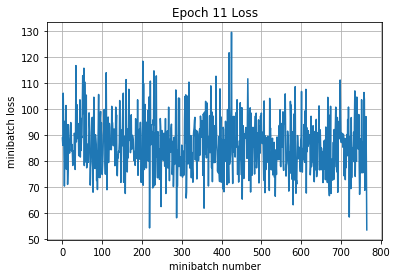

Iteration 8500: with minibatch training loss = 1.25 and accuracy of 0.55
Iteration 8600: with minibatch training loss = 1.4 and accuracy of 0.52
Iteration 8700: with minibatch training loss = 1.43 and accuracy of 0.52
Iteration 8800: with minibatch training loss = 1.31 and accuracy of 0.62
Iteration 8900: with minibatch training loss = 1.38 and accuracy of 0.52
Iteration 9000: with minibatch training loss = 1.53 and accuracy of 0.48
Iteration 9100: with minibatch training loss = 1.5 and accuracy of 0.52
Epoch 12, Overall loss = 1.3 and accuracy of 0.552


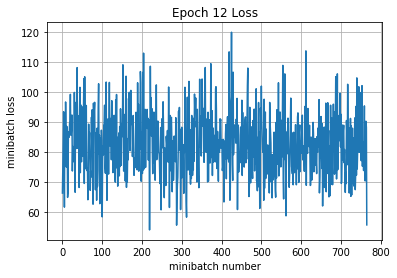

Iteration 9200: with minibatch training loss = 1.36 and accuracy of 0.5
Iteration 9300: with minibatch training loss = 1.07 and accuracy of 0.64
Iteration 9400: with minibatch training loss = 1.36 and accuracy of 0.52
Iteration 9500: with minibatch training loss = 1.28 and accuracy of 0.58
Iteration 9600: with minibatch training loss = 1.1 and accuracy of 0.66
Iteration 9700: with minibatch training loss = 1.03 and accuracy of 0.58
Iteration 9800: with minibatch training loss = 1.23 and accuracy of 0.66
Iteration 9900: with minibatch training loss = 1.37 and accuracy of 0.48
Epoch 13, Overall loss = 1.24 and accuracy of 0.57


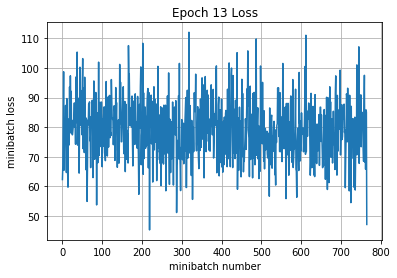

Iteration 10000: with minibatch training loss = 1.21 and accuracy of 0.56
Iteration 10100: with minibatch training loss = 1.08 and accuracy of 0.59
Iteration 10200: with minibatch training loss = 1.17 and accuracy of 0.52
Iteration 10300: with minibatch training loss = 1.07 and accuracy of 0.67
Iteration 10400: with minibatch training loss = 1.35 and accuracy of 0.5
Iteration 10500: with minibatch training loss = 1.24 and accuracy of 0.56
Iteration 10600: with minibatch training loss = 1.14 and accuracy of 0.56
Iteration 10700: with minibatch training loss = 1.27 and accuracy of 0.52
Epoch 14, Overall loss = 1.19 and accuracy of 0.587


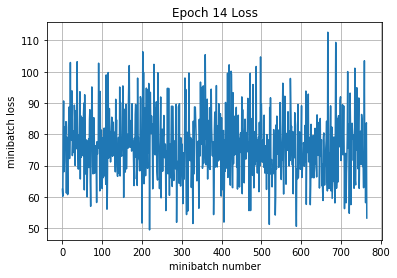

Iteration 10800: with minibatch training loss = 1.11 and accuracy of 0.62
Iteration 10900: with minibatch training loss = 1.09 and accuracy of 0.55
Iteration 11000: with minibatch training loss = 0.952 and accuracy of 0.61
Iteration 11100: with minibatch training loss = 1.33 and accuracy of 0.5
Iteration 11200: with minibatch training loss = 1.01 and accuracy of 0.72
Iteration 11300: with minibatch training loss = 1.25 and accuracy of 0.52
Iteration 11400: with minibatch training loss = 0.957 and accuracy of 0.7
Epoch 15, Overall loss = 1.15 and accuracy of 0.604


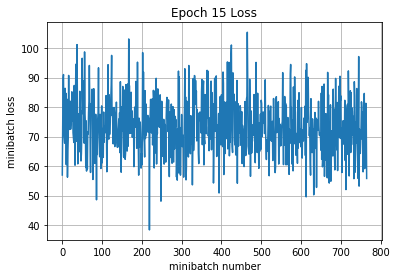

Iteration 11500: with minibatch training loss = 1.01 and accuracy of 0.67
Iteration 11600: with minibatch training loss = 1.36 and accuracy of 0.48
Iteration 11700: with minibatch training loss = 1.14 and accuracy of 0.58
Iteration 11800: with minibatch training loss = 1.24 and accuracy of 0.64
Iteration 11900: with minibatch training loss = 1.3 and accuracy of 0.52
Iteration 12000: with minibatch training loss = 1.01 and accuracy of 0.62
Iteration 12100: with minibatch training loss = 1.28 and accuracy of 0.55
Iteration 12200: with minibatch training loss = 1.19 and accuracy of 0.62
Epoch 16, Overall loss = 1.11 and accuracy of 0.619


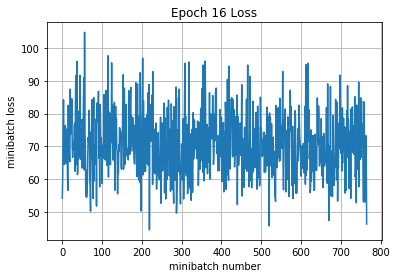

Iteration 12300: with minibatch training loss = 1.39 and accuracy of 0.53
Iteration 12400: with minibatch training loss = 1.08 and accuracy of 0.56
Iteration 12500: with minibatch training loss = 0.872 and accuracy of 0.7
Iteration 12600: with minibatch training loss = 1.08 and accuracy of 0.58
Iteration 12700: with minibatch training loss = 1.08 and accuracy of 0.58
Iteration 12800: with minibatch training loss = 0.859 and accuracy of 0.75
Iteration 12900: with minibatch training loss = 1.01 and accuracy of 0.64
Iteration 13000: with minibatch training loss = 0.995 and accuracy of 0.69
Epoch 17, Overall loss = 1.07 and accuracy of 0.631


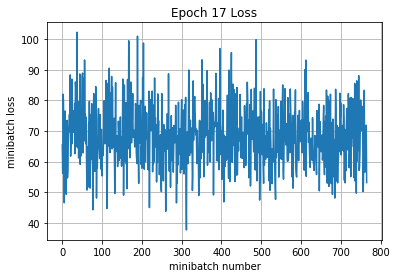

Iteration 13100: with minibatch training loss = 1.01 and accuracy of 0.62
Iteration 13200: with minibatch training loss = 0.955 and accuracy of 0.66
Iteration 13300: with minibatch training loss = 1.05 and accuracy of 0.66
Iteration 13400: with minibatch training loss = 1.11 and accuracy of 0.7
Iteration 13500: with minibatch training loss = 0.971 and accuracy of 0.66
Iteration 13600: with minibatch training loss = 0.911 and accuracy of 0.69
Iteration 13700: with minibatch training loss = 1.06 and accuracy of 0.64
Epoch 18, Overall loss = 1.04 and accuracy of 0.64


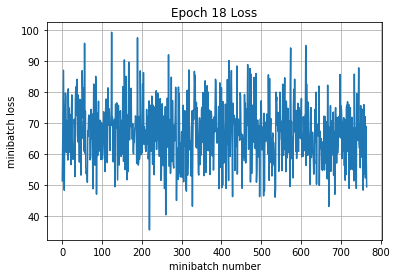

Iteration 13800: with minibatch training loss = 1.15 and accuracy of 0.61
Iteration 13900: with minibatch training loss = 0.792 and accuracy of 0.69
Iteration 14000: with minibatch training loss = 0.846 and accuracy of 0.72
Iteration 14100: with minibatch training loss = 0.697 and accuracy of 0.72
Iteration 14200: with minibatch training loss = 0.826 and accuracy of 0.7
Iteration 14300: with minibatch training loss = 1.08 and accuracy of 0.56
Iteration 14400: with minibatch training loss = 1.41 and accuracy of 0.53
Iteration 14500: with minibatch training loss = 1.11 and accuracy of 0.59
Epoch 19, Overall loss = 1.01 and accuracy of 0.65


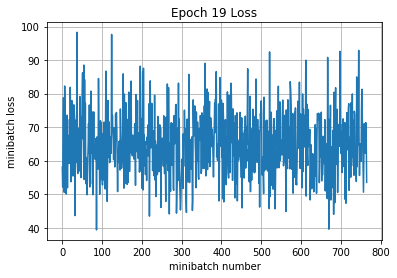

Iteration 14600: with minibatch training loss = 1.12 and accuracy of 0.64
Iteration 14700: with minibatch training loss = 1.11 and accuracy of 0.64
Iteration 14800: with minibatch training loss = 0.868 and accuracy of 0.72
Iteration 14900: with minibatch training loss = 0.853 and accuracy of 0.72
Iteration 15000: with minibatch training loss = 0.904 and accuracy of 0.64
Iteration 15100: with minibatch training loss = 0.927 and accuracy of 0.73
Iteration 15200: with minibatch training loss = 0.825 and accuracy of 0.66
Iteration 15300: with minibatch training loss = 0.977 and accuracy of 0.72
Epoch 20, Overall loss = 0.981 and accuracy of 0.66


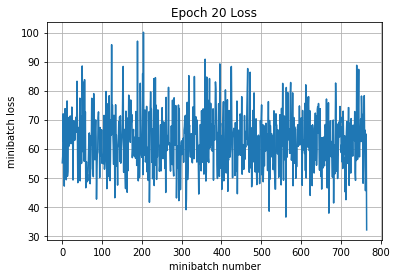

Iteration 15400: with minibatch training loss = 0.815 and accuracy of 0.73
Iteration 15500: with minibatch training loss = 0.915 and accuracy of 0.66
Iteration 15600: with minibatch training loss = 0.757 and accuracy of 0.77
Iteration 15700: with minibatch training loss = 0.824 and accuracy of 0.72
Iteration 15800: with minibatch training loss = 0.884 and accuracy of 0.66
Iteration 15900: with minibatch training loss = 0.649 and accuracy of 0.78
Iteration 16000: with minibatch training loss = 0.947 and accuracy of 0.72
Epoch 21, Overall loss = 0.954 and accuracy of 0.668


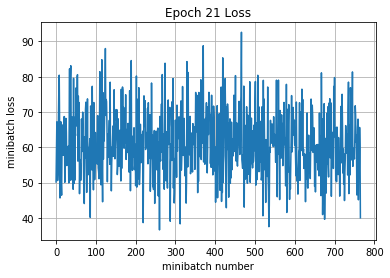

Iteration 16100: with minibatch training loss = 0.846 and accuracy of 0.64
Iteration 16200: with minibatch training loss = 0.953 and accuracy of 0.64
Iteration 16300: with minibatch training loss = 0.902 and accuracy of 0.69
Iteration 16400: with minibatch training loss = 0.993 and accuracy of 0.67
Iteration 16500: with minibatch training loss = 0.857 and accuracy of 0.7
Iteration 16600: with minibatch training loss = 0.99 and accuracy of 0.61
Iteration 16700: with minibatch training loss = 1.26 and accuracy of 0.59
Iteration 16800: with minibatch training loss = 0.89 and accuracy of 0.69
Epoch 22, Overall loss = 0.925 and accuracy of 0.68


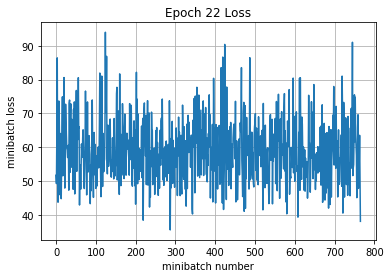

Iteration 16900: with minibatch training loss = 0.878 and accuracy of 0.67
Iteration 17000: with minibatch training loss = 0.904 and accuracy of 0.7
Iteration 17100: with minibatch training loss = 0.658 and accuracy of 0.75
Iteration 17200: with minibatch training loss = 0.992 and accuracy of 0.64
Iteration 17300: with minibatch training loss = 0.835 and accuracy of 0.66
Iteration 17400: with minibatch training loss = 0.857 and accuracy of 0.7
Iteration 17500: with minibatch training loss = 1.03 and accuracy of 0.58
Iteration 17600: with minibatch training loss = 0.92 and accuracy of 0.73
Epoch 23, Overall loss = 0.903 and accuracy of 0.688


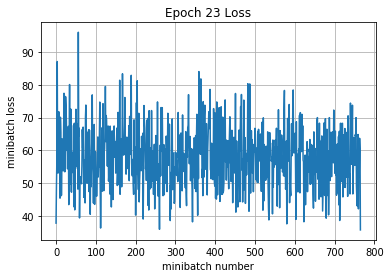

Iteration 17700: with minibatch training loss = 0.865 and accuracy of 0.7
Iteration 17800: with minibatch training loss = 0.838 and accuracy of 0.69
Iteration 17900: with minibatch training loss = 0.776 and accuracy of 0.75
Iteration 18000: with minibatch training loss = 0.941 and accuracy of 0.69
Iteration 18100: with minibatch training loss = 0.993 and accuracy of 0.66
Iteration 18200: with minibatch training loss = 1.05 and accuracy of 0.62
Iteration 18300: with minibatch training loss = 0.667 and accuracy of 0.78
Epoch 24, Overall loss = 0.881 and accuracy of 0.696


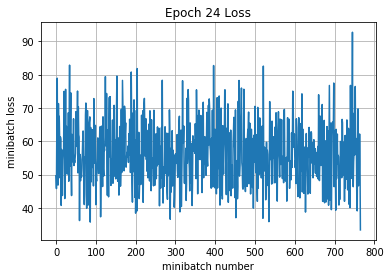

Iteration 18400: with minibatch training loss = 0.957 and accuracy of 0.67
Iteration 18500: with minibatch training loss = 0.851 and accuracy of 0.7
Iteration 18600: with minibatch training loss = 0.763 and accuracy of 0.72
Iteration 18700: with minibatch training loss = 0.752 and accuracy of 0.7
Iteration 18800: with minibatch training loss = 0.716 and accuracy of 0.75
Iteration 18900: with minibatch training loss = 0.647 and accuracy of 0.81
Iteration 19000: with minibatch training loss = 0.915 and accuracy of 0.72
Iteration 19100: with minibatch training loss = 0.998 and accuracy of 0.61
Epoch 25, Overall loss = 0.86 and accuracy of 0.703


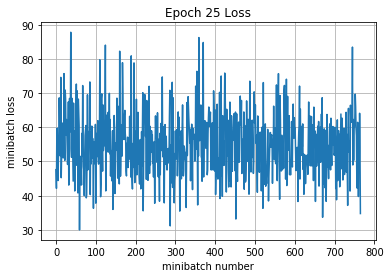

Iteration 19200: with minibatch training loss = 1.22 and accuracy of 0.58
Iteration 19300: with minibatch training loss = 0.754 and accuracy of 0.7
Iteration 19400: with minibatch training loss = 0.95 and accuracy of 0.7
Iteration 19500: with minibatch training loss = 1.05 and accuracy of 0.66
Iteration 19600: with minibatch training loss = 0.862 and accuracy of 0.7
Iteration 19700: with minibatch training loss = 0.79 and accuracy of 0.77
Iteration 19800: with minibatch training loss = 0.751 and accuracy of 0.77
Iteration 19900: with minibatch training loss = 0.937 and accuracy of 0.69
Epoch 26, Overall loss = 0.842 and accuracy of 0.708


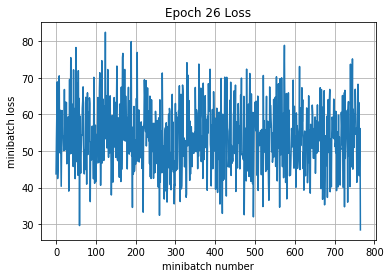

Iteration 20000: with minibatch training loss = 0.834 and accuracy of 0.67
Iteration 20100: with minibatch training loss = 0.715 and accuracy of 0.77
Iteration 20200: with minibatch training loss = 0.804 and accuracy of 0.73
Iteration 20300: with minibatch training loss = 0.956 and accuracy of 0.67
Iteration 20400: with minibatch training loss = 0.986 and accuracy of 0.67
Iteration 20500: with minibatch training loss = 0.764 and accuracy of 0.75
Iteration 20600: with minibatch training loss = 0.924 and accuracy of 0.7
Epoch 27, Overall loss = 0.822 and accuracy of 0.715


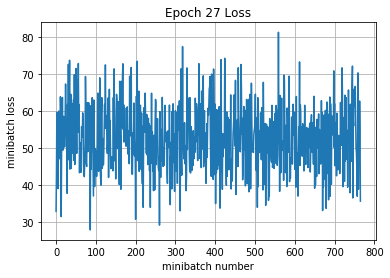

Iteration 20700: with minibatch training loss = 0.688 and accuracy of 0.72
Iteration 20800: with minibatch training loss = 0.789 and accuracy of 0.72
Iteration 20900: with minibatch training loss = 0.884 and accuracy of 0.7
Iteration 21000: with minibatch training loss = 1.04 and accuracy of 0.67
Iteration 21100: with minibatch training loss = 0.53 and accuracy of 0.84
Iteration 21200: with minibatch training loss = 0.897 and accuracy of 0.67
Iteration 21300: with minibatch training loss = 1.08 and accuracy of 0.62
Iteration 21400: with minibatch training loss = 0.734 and accuracy of 0.77
Epoch 28, Overall loss = 0.802 and accuracy of 0.723


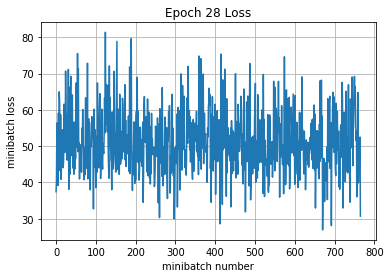

Iteration 21500: with minibatch training loss = 0.824 and accuracy of 0.67
Iteration 21600: with minibatch training loss = 0.81 and accuracy of 0.77
Iteration 21700: with minibatch training loss = 0.838 and accuracy of 0.69
Iteration 21800: with minibatch training loss = 0.742 and accuracy of 0.73
Iteration 21900: with minibatch training loss = 0.684 and accuracy of 0.73
Iteration 22000: with minibatch training loss = 0.697 and accuracy of 0.8
Iteration 22100: with minibatch training loss = 0.767 and accuracy of 0.77
Iteration 22200: with minibatch training loss = 1.01 and accuracy of 0.72
Epoch 29, Overall loss = 0.789 and accuracy of 0.727


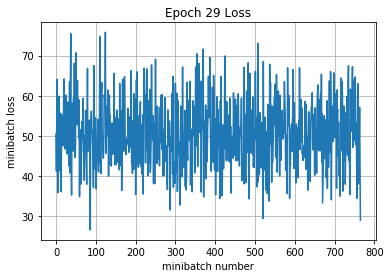

Iteration 22300: with minibatch training loss = 0.524 and accuracy of 0.81
Iteration 22400: with minibatch training loss = 0.848 and accuracy of 0.72
Iteration 22500: with minibatch training loss = 0.948 and accuracy of 0.67
Iteration 22600: with minibatch training loss = 0.935 and accuracy of 0.7
Iteration 22700: with minibatch training loss = 0.816 and accuracy of 0.69
Iteration 22800: with minibatch training loss = 0.982 and accuracy of 0.7
Iteration 22900: with minibatch training loss = 0.722 and accuracy of 0.72
Epoch 30, Overall loss = 0.777 and accuracy of 0.733


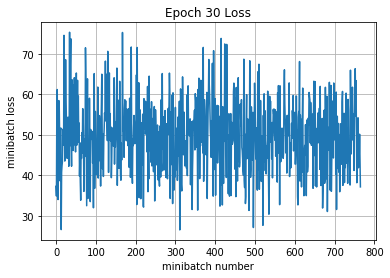

Iteration 23000: with minibatch training loss = 0.869 and accuracy of 0.72
Iteration 23100: with minibatch training loss = 0.678 and accuracy of 0.78
Iteration 23200: with minibatch training loss = 0.64 and accuracy of 0.84
Iteration 23300: with minibatch training loss = 0.737 and accuracy of 0.72
Iteration 23400: with minibatch training loss = 0.635 and accuracy of 0.75
Iteration 23500: with minibatch training loss = 0.484 and accuracy of 0.83
Iteration 23600: with minibatch training loss = 0.694 and accuracy of 0.72
Iteration 23700: with minibatch training loss = 0.738 and accuracy of 0.77
Epoch 31, Overall loss = 0.76 and accuracy of 0.739


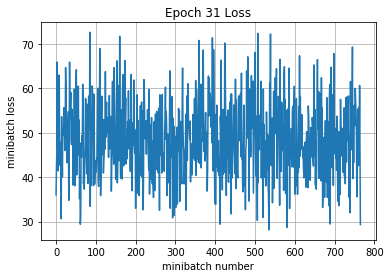

Iteration 23800: with minibatch training loss = 0.853 and accuracy of 0.73
Iteration 23900: with minibatch training loss = 0.584 and accuracy of 0.8
Iteration 24000: with minibatch training loss = 0.651 and accuracy of 0.77
Iteration 24100: with minibatch training loss = 0.8 and accuracy of 0.73
Iteration 24200: with minibatch training loss = 0.704 and accuracy of 0.72
Iteration 24300: with minibatch training loss = 1.11 and accuracy of 0.62
Iteration 24400: with minibatch training loss = 0.735 and accuracy of 0.73
Iteration 24500: with minibatch training loss = 0.9 and accuracy of 0.61
Epoch 32, Overall loss = 0.75 and accuracy of 0.742


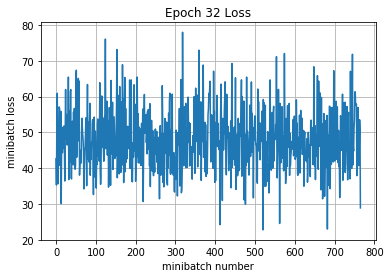

Iteration 24600: with minibatch training loss = 0.748 and accuracy of 0.69
Iteration 24700: with minibatch training loss = 0.692 and accuracy of 0.77
Iteration 24800: with minibatch training loss = 0.738 and accuracy of 0.7
Iteration 24900: with minibatch training loss = 0.746 and accuracy of 0.72
Iteration 25000: with minibatch training loss = 0.553 and accuracy of 0.81
Iteration 25100: with minibatch training loss = 0.629 and accuracy of 0.84
Iteration 25200: with minibatch training loss = 0.856 and accuracy of 0.7
Epoch 33, Overall loss = 0.736 and accuracy of 0.749


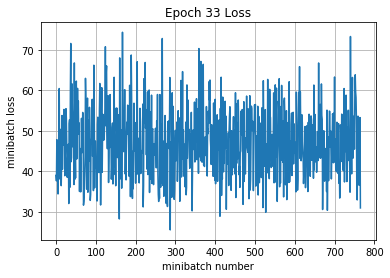

Iteration 25300: with minibatch training loss = 0.566 and accuracy of 0.75
Iteration 25400: with minibatch training loss = 0.774 and accuracy of 0.73
Iteration 25500: with minibatch training loss = 0.911 and accuracy of 0.69
Iteration 25600: with minibatch training loss = 0.868 and accuracy of 0.72
Iteration 25700: with minibatch training loss = 0.8 and accuracy of 0.69
Iteration 25800: with minibatch training loss = 0.652 and accuracy of 0.8
Iteration 25900: with minibatch training loss = 0.672 and accuracy of 0.77
Iteration 26000: with minibatch training loss = 0.661 and accuracy of 0.75
Epoch 34, Overall loss = 0.723 and accuracy of 0.754


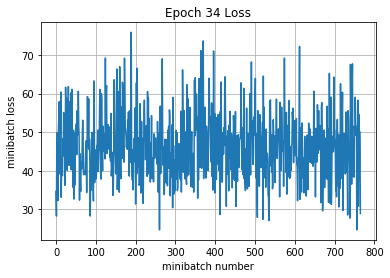

Iteration 26100: with minibatch training loss = 1.07 and accuracy of 0.62
Iteration 26200: with minibatch training loss = 0.83 and accuracy of 0.72
Iteration 26300: with minibatch training loss = 0.625 and accuracy of 0.84
Iteration 26400: with minibatch training loss = 0.601 and accuracy of 0.73
Iteration 26500: with minibatch training loss = 0.634 and accuracy of 0.78
Iteration 26600: with minibatch training loss = 0.575 and accuracy of 0.8
Iteration 26700: with minibatch training loss = 0.649 and accuracy of 0.75
Iteration 26800: with minibatch training loss = 0.493 and accuracy of 0.8
Epoch 35, Overall loss = 0.709 and accuracy of 0.755


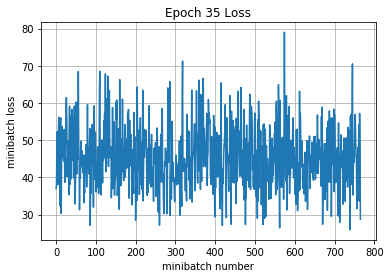

Iteration 26900: with minibatch training loss = 0.663 and accuracy of 0.75
Iteration 27000: with minibatch training loss = 0.753 and accuracy of 0.67
Iteration 27100: with minibatch training loss = 0.753 and accuracy of 0.72
Iteration 27200: with minibatch training loss = 0.581 and accuracy of 0.77
Iteration 27300: with minibatch training loss = 0.618 and accuracy of 0.75
Iteration 27400: with minibatch training loss = 0.527 and accuracy of 0.86
Iteration 27500: with minibatch training loss = 0.83 and accuracy of 0.72
Epoch 36, Overall loss = 0.698 and accuracy of 0.759


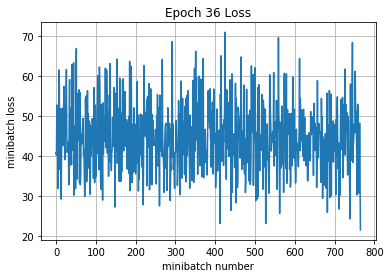

Iteration 27600: with minibatch training loss = 0.768 and accuracy of 0.73
Iteration 27700: with minibatch training loss = 1.04 and accuracy of 0.64
Iteration 27800: with minibatch training loss = 0.723 and accuracy of 0.78
Iteration 27900: with minibatch training loss = 0.822 and accuracy of 0.73
Iteration 28000: with minibatch training loss = 0.837 and accuracy of 0.69
Iteration 28100: with minibatch training loss = 0.577 and accuracy of 0.83
Iteration 28200: with minibatch training loss = 0.582 and accuracy of 0.75
Iteration 28300: with minibatch training loss = 0.727 and accuracy of 0.73
Epoch 37, Overall loss = 0.684 and accuracy of 0.766


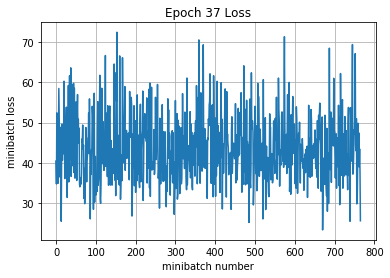

Iteration 28400: with minibatch training loss = 0.746 and accuracy of 0.72
Iteration 28500: with minibatch training loss = 0.566 and accuracy of 0.77
Iteration 28600: with minibatch training loss = 0.587 and accuracy of 0.77
Iteration 28700: with minibatch training loss = 0.624 and accuracy of 0.75
Iteration 28800: with minibatch training loss = 0.832 and accuracy of 0.73
Iteration 28900: with minibatch training loss = 0.711 and accuracy of 0.8
Iteration 29000: with minibatch training loss = 0.738 and accuracy of 0.72
Iteration 29100: with minibatch training loss = 0.673 and accuracy of 0.75
Epoch 38, Overall loss = 0.678 and accuracy of 0.766


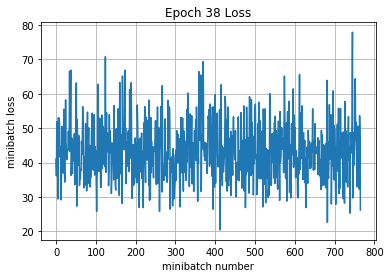

Iteration 29200: with minibatch training loss = 0.603 and accuracy of 0.77
Iteration 29300: with minibatch training loss = 0.579 and accuracy of 0.78
Iteration 29400: with minibatch training loss = 0.722 and accuracy of 0.72
Iteration 29500: with minibatch training loss = 0.627 and accuracy of 0.83
Iteration 29600: with minibatch training loss = 0.675 and accuracy of 0.73
Iteration 29700: with minibatch training loss = 0.734 and accuracy of 0.77
Iteration 29800: with minibatch training loss = 0.37 and accuracy of 0.92
Epoch 39, Overall loss = 0.664 and accuracy of 0.771


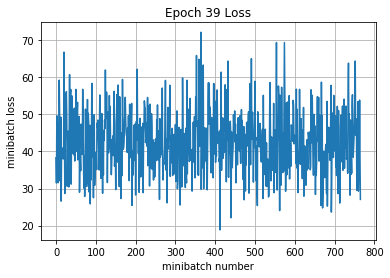

Iteration 29900: with minibatch training loss = 0.89 and accuracy of 0.7
Iteration 30000: with minibatch training loss = 0.774 and accuracy of 0.72
Iteration 30100: with minibatch training loss = 0.805 and accuracy of 0.72
Iteration 30200: with minibatch training loss = 0.649 and accuracy of 0.73
Iteration 30300: with minibatch training loss = 0.75 and accuracy of 0.73
Iteration 30400: with minibatch training loss = 0.782 and accuracy of 0.75
Iteration 30500: with minibatch training loss = 0.696 and accuracy of 0.8
Iteration 30600: with minibatch training loss = 0.807 and accuracy of 0.64
Epoch 40, Overall loss = 0.653 and accuracy of 0.776


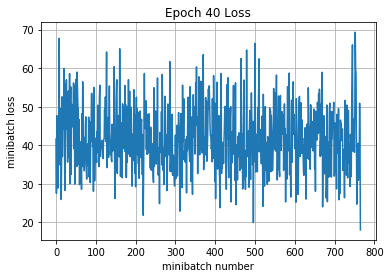

Iteration 30700: with minibatch training loss = 0.536 and accuracy of 0.81
Iteration 30800: with minibatch training loss = 0.689 and accuracy of 0.78
Iteration 30900: with minibatch training loss = 0.342 and accuracy of 0.86
Iteration 31000: with minibatch training loss = 0.723 and accuracy of 0.8
Iteration 31100: with minibatch training loss = 0.585 and accuracy of 0.83
Iteration 31200: with minibatch training loss = 0.735 and accuracy of 0.77
Iteration 31300: with minibatch training loss = 0.755 and accuracy of 0.7
Iteration 31400: with minibatch training loss = 0.552 and accuracy of 0.81
Epoch 41, Overall loss = 0.642 and accuracy of 0.777


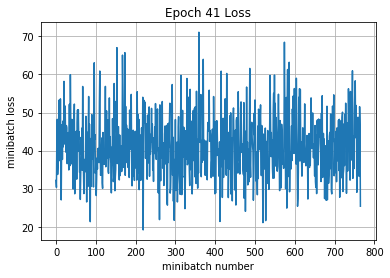

Iteration 31500: with minibatch training loss = 0.415 and accuracy of 0.84
Iteration 31600: with minibatch training loss = 0.596 and accuracy of 0.8
Iteration 31700: with minibatch training loss = 0.713 and accuracy of 0.69
Iteration 31800: with minibatch training loss = 0.595 and accuracy of 0.73
Iteration 31900: with minibatch training loss = 0.517 and accuracy of 0.81
Iteration 32000: with minibatch training loss = 0.879 and accuracy of 0.73
Iteration 32100: with minibatch training loss = 0.67 and accuracy of 0.75
Epoch 42, Overall loss = 0.63 and accuracy of 0.783


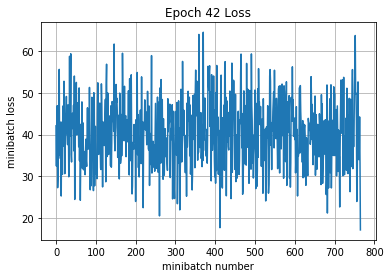

Iteration 32200: with minibatch training loss = 0.42 and accuracy of 0.88
Iteration 32300: with minibatch training loss = 0.681 and accuracy of 0.75
Iteration 32400: with minibatch training loss = 0.646 and accuracy of 0.75
Iteration 32500: with minibatch training loss = 0.392 and accuracy of 0.89
Iteration 32600: with minibatch training loss = 0.403 and accuracy of 0.84
Iteration 32700: with minibatch training loss = 0.573 and accuracy of 0.81
Iteration 32800: with minibatch training loss = 0.476 and accuracy of 0.84
Iteration 32900: with minibatch training loss = 0.591 and accuracy of 0.77
Epoch 43, Overall loss = 0.625 and accuracy of 0.786


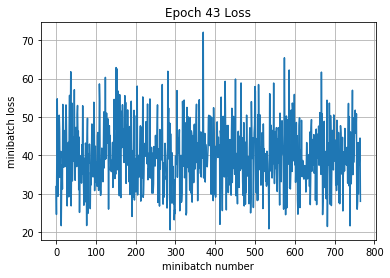

Iteration 33000: with minibatch training loss = 0.605 and accuracy of 0.78
Iteration 33100: with minibatch training loss = 0.443 and accuracy of 0.89
Iteration 33200: with minibatch training loss = 0.61 and accuracy of 0.81
Iteration 33300: with minibatch training loss = 0.369 and accuracy of 0.91
Iteration 33400: with minibatch training loss = 0.6 and accuracy of 0.81
Iteration 33500: with minibatch training loss = 0.473 and accuracy of 0.84
Iteration 33600: with minibatch training loss = 0.706 and accuracy of 0.73
Iteration 33700: with minibatch training loss = 0.439 and accuracy of 0.86
Epoch 44, Overall loss = 0.614 and accuracy of 0.789


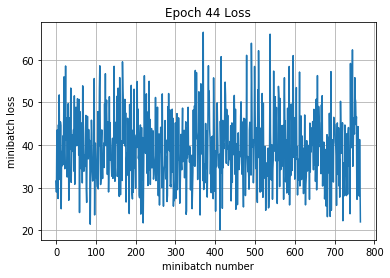

Iteration 33800: with minibatch training loss = 0.836 and accuracy of 0.72
Iteration 33900: with minibatch training loss = 0.607 and accuracy of 0.78
Iteration 34000: with minibatch training loss = 0.569 and accuracy of 0.83
Iteration 34100: with minibatch training loss = 0.767 and accuracy of 0.72
Iteration 34200: with minibatch training loss = 0.381 and accuracy of 0.89
Iteration 34300: with minibatch training loss = 0.745 and accuracy of 0.78
Iteration 34400: with minibatch training loss = 0.563 and accuracy of 0.75
Epoch 45, Overall loss = 0.609 and accuracy of 0.79


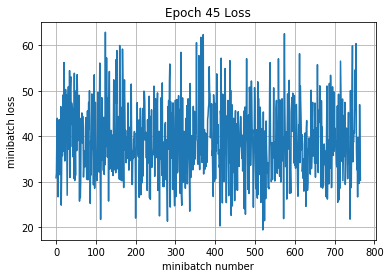

Iteration 34500: with minibatch training loss = 0.506 and accuracy of 0.86
Iteration 34600: with minibatch training loss = 0.799 and accuracy of 0.77
Iteration 34700: with minibatch training loss = 0.622 and accuracy of 0.77
Iteration 34800: with minibatch training loss = 0.651 and accuracy of 0.81
Iteration 34900: with minibatch training loss = 0.568 and accuracy of 0.8
Iteration 35000: with minibatch training loss = 0.548 and accuracy of 0.81
Iteration 35100: with minibatch training loss = 0.59 and accuracy of 0.75
Iteration 35200: with minibatch training loss = 0.398 and accuracy of 0.89
Epoch 46, Overall loss = 0.597 and accuracy of 0.796


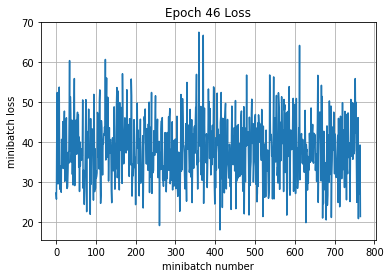

Iteration 35300: with minibatch training loss = 0.646 and accuracy of 0.8
Iteration 35400: with minibatch training loss = 0.651 and accuracy of 0.73
Iteration 35500: with minibatch training loss = 0.867 and accuracy of 0.73
Iteration 35600: with minibatch training loss = 0.92 and accuracy of 0.69
Iteration 35700: with minibatch training loss = 0.602 and accuracy of 0.78
Iteration 35800: with minibatch training loss = 0.541 and accuracy of 0.81
Iteration 35900: with minibatch training loss = 0.733 and accuracy of 0.78
Iteration 36000: with minibatch training loss = 0.526 and accuracy of 0.88
Epoch 47, Overall loss = 0.587 and accuracy of 0.797


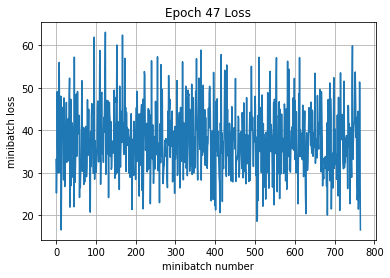

Iteration 36100: with minibatch training loss = 0.48 and accuracy of 0.84
Iteration 36200: with minibatch training loss = 0.576 and accuracy of 0.8
Iteration 36300: with minibatch training loss = 0.461 and accuracy of 0.84
Iteration 36400: with minibatch training loss = 0.476 and accuracy of 0.83
Iteration 36500: with minibatch training loss = 0.771 and accuracy of 0.69
Iteration 36600: with minibatch training loss = 0.501 and accuracy of 0.83
Iteration 36700: with minibatch training loss = 0.638 and accuracy of 0.77
Epoch 48, Overall loss = 0.584 and accuracy of 0.799


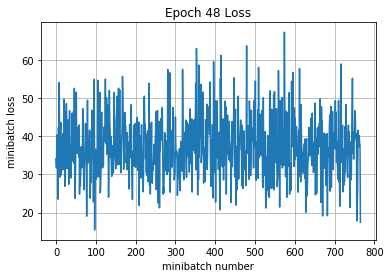

Iteration 36800: with minibatch training loss = 0.445 and accuracy of 0.81
Iteration 36900: with minibatch training loss = 0.443 and accuracy of 0.88
Iteration 37000: with minibatch training loss = 0.58 and accuracy of 0.77
Iteration 37100: with minibatch training loss = 0.701 and accuracy of 0.77
Iteration 37200: with minibatch training loss = 0.727 and accuracy of 0.78
Iteration 37300: with minibatch training loss = 0.662 and accuracy of 0.77
Iteration 37400: with minibatch training loss = 0.409 and accuracy of 0.89
Iteration 37500: with minibatch training loss = 0.412 and accuracy of 0.86
Epoch 49, Overall loss = 0.571 and accuracy of 0.802


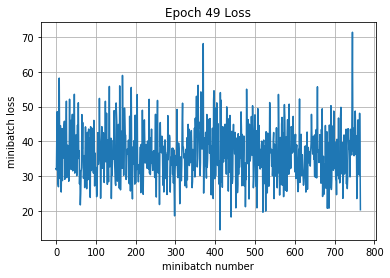

Iteration 37600: with minibatch training loss = 0.436 and accuracy of 0.86
Iteration 37700: with minibatch training loss = 0.484 and accuracy of 0.81
Iteration 37800: with minibatch training loss = 0.533 and accuracy of 0.83
Iteration 37900: with minibatch training loss = 0.574 and accuracy of 0.78
Iteration 38000: with minibatch training loss = 0.61 and accuracy of 0.81
Iteration 38100: with minibatch training loss = 0.403 and accuracy of 0.88
Iteration 38200: with minibatch training loss = 0.418 and accuracy of 0.89
Epoch 50, Overall loss = 0.564 and accuracy of 0.807


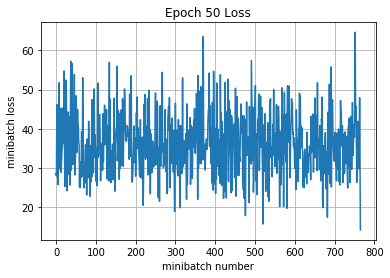

Iteration 38300: with minibatch training loss = 0.397 and accuracy of 0.91
Iteration 38400: with minibatch training loss = 0.534 and accuracy of 0.83
Iteration 38500: with minibatch training loss = 0.439 and accuracy of 0.84
Iteration 38600: with minibatch training loss = 0.681 and accuracy of 0.78
Iteration 38700: with minibatch training loss = 0.752 and accuracy of 0.75
Iteration 38800: with minibatch training loss = 0.76 and accuracy of 0.75
Iteration 38900: with minibatch training loss = 0.552 and accuracy of 0.8
Iteration 39000: with minibatch training loss = 0.554 and accuracy of 0.8
Epoch 51, Overall loss = 0.557 and accuracy of 0.81


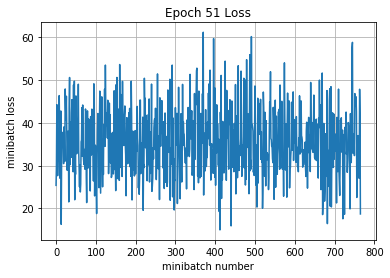

Iteration 39100: with minibatch training loss = 0.64 and accuracy of 0.83
Iteration 39200: with minibatch training loss = 0.541 and accuracy of 0.78
Iteration 39300: with minibatch training loss = 0.758 and accuracy of 0.7
Iteration 39400: with minibatch training loss = 0.483 and accuracy of 0.84
Iteration 39500: with minibatch training loss = 0.529 and accuracy of 0.84
Iteration 39600: with minibatch training loss = 0.437 and accuracy of 0.83
Iteration 39700: with minibatch training loss = 0.551 and accuracy of 0.8
Iteration 39800: with minibatch training loss = 0.581 and accuracy of 0.8
Epoch 52, Overall loss = 0.549 and accuracy of 0.812


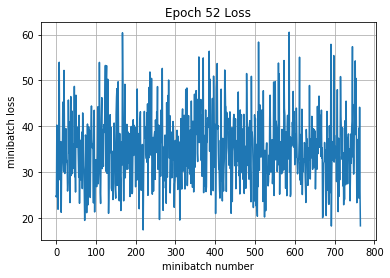

Iteration 39900: with minibatch training loss = 0.43 and accuracy of 0.86
Iteration 40000: with minibatch training loss = 0.65 and accuracy of 0.77
Iteration 40100: with minibatch training loss = 0.554 and accuracy of 0.78
Iteration 40200: with minibatch training loss = 0.448 and accuracy of 0.88
Iteration 40300: with minibatch training loss = 0.568 and accuracy of 0.81
Iteration 40400: with minibatch training loss = 0.697 and accuracy of 0.73
Iteration 40500: with minibatch training loss = 0.527 and accuracy of 0.83
Epoch 53, Overall loss = 0.541 and accuracy of 0.815


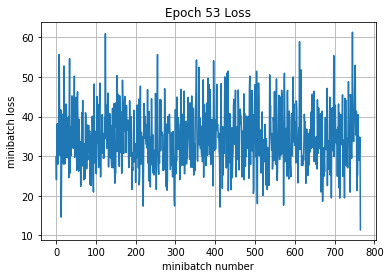

Iteration 40600: with minibatch training loss = 0.618 and accuracy of 0.77
Iteration 40700: with minibatch training loss = 0.456 and accuracy of 0.89
Iteration 40800: with minibatch training loss = 0.554 and accuracy of 0.8
Iteration 40900: with minibatch training loss = 0.49 and accuracy of 0.8
Iteration 41000: with minibatch training loss = 0.588 and accuracy of 0.84
Iteration 41100: with minibatch training loss = 0.554 and accuracy of 0.77
Iteration 41200: with minibatch training loss = 0.535 and accuracy of 0.81
Iteration 41300: with minibatch training loss = 0.561 and accuracy of 0.84
Epoch 54, Overall loss = 0.539 and accuracy of 0.815


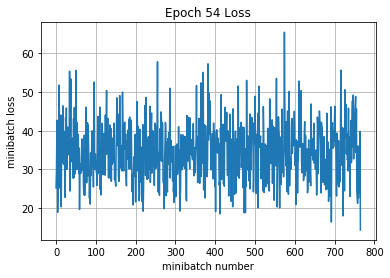

Iteration 41400: with minibatch training loss = 0.723 and accuracy of 0.77
Iteration 41500: with minibatch training loss = 0.476 and accuracy of 0.81
Iteration 41600: with minibatch training loss = 0.501 and accuracy of 0.83
Iteration 41700: with minibatch training loss = 0.538 and accuracy of 0.83
Iteration 41800: with minibatch training loss = 0.606 and accuracy of 0.83
Iteration 41900: with minibatch training loss = 0.38 and accuracy of 0.84
Iteration 42000: with minibatch training loss = 0.384 and accuracy of 0.89
Iteration 42100: with minibatch training loss = 0.446 and accuracy of 0.86
Epoch 55, Overall loss = 0.524 and accuracy of 0.821


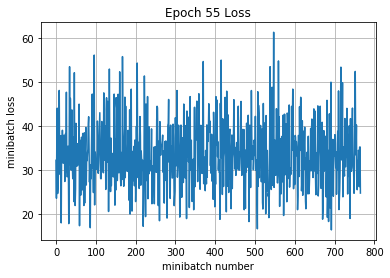

Iteration 42200: with minibatch training loss = 0.316 and accuracy of 0.89
Iteration 42300: with minibatch training loss = 0.496 and accuracy of 0.86
Iteration 42400: with minibatch training loss = 0.376 and accuracy of 0.89
Iteration 42500: with minibatch training loss = 0.965 and accuracy of 0.67
Iteration 42600: with minibatch training loss = 0.494 and accuracy of 0.8
Iteration 42700: with minibatch training loss = 0.54 and accuracy of 0.8
Iteration 42800: with minibatch training loss = 0.29 and accuracy of 0.94
Epoch 56, Overall loss = 0.524 and accuracy of 0.82


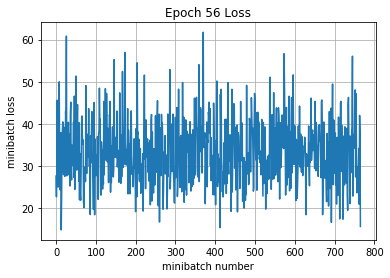

Iteration 42900: with minibatch training loss = 0.335 and accuracy of 0.89
Iteration 43000: with minibatch training loss = 0.552 and accuracy of 0.83
Iteration 43100: with minibatch training loss = 0.713 and accuracy of 0.7
Iteration 43200: with minibatch training loss = 0.633 and accuracy of 0.78
Iteration 43300: with minibatch training loss = 0.621 and accuracy of 0.8
Iteration 43400: with minibatch training loss = 0.651 and accuracy of 0.75
Iteration 43500: with minibatch training loss = 0.679 and accuracy of 0.8
Iteration 43600: with minibatch training loss = 0.497 and accuracy of 0.78
Epoch 57, Overall loss = 0.513 and accuracy of 0.824


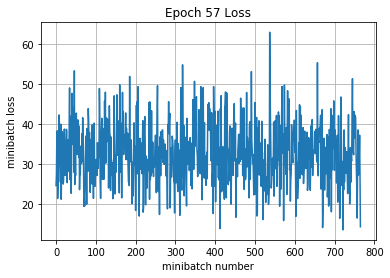

Iteration 43700: with minibatch training loss = 0.45 and accuracy of 0.81
Iteration 43800: with minibatch training loss = 0.558 and accuracy of 0.81
Iteration 43900: with minibatch training loss = 0.511 and accuracy of 0.84
Iteration 44000: with minibatch training loss = 0.413 and accuracy of 0.88
Iteration 44100: with minibatch training loss = 0.515 and accuracy of 0.8
Iteration 44200: with minibatch training loss = 0.798 and accuracy of 0.7
Iteration 44300: with minibatch training loss = 0.588 and accuracy of 0.78
Iteration 44400: with minibatch training loss = 0.519 and accuracy of 0.8
Epoch 58, Overall loss = 0.511 and accuracy of 0.824


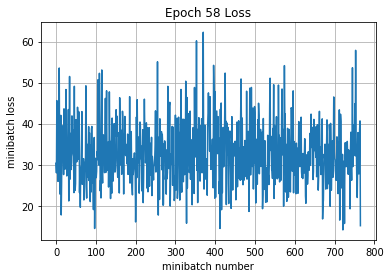

Iteration 44500: with minibatch training loss = 0.334 and accuracy of 0.89
Iteration 44600: with minibatch training loss = 0.486 and accuracy of 0.84
Iteration 44700: with minibatch training loss = 0.415 and accuracy of 0.8
Iteration 44800: with minibatch training loss = 0.494 and accuracy of 0.83
Iteration 44900: with minibatch training loss = 0.718 and accuracy of 0.75
Iteration 45000: with minibatch training loss = 0.342 and accuracy of 0.92
Iteration 45100: with minibatch training loss = 0.33 and accuracy of 0.92
Epoch 59, Overall loss = 0.504 and accuracy of 0.827


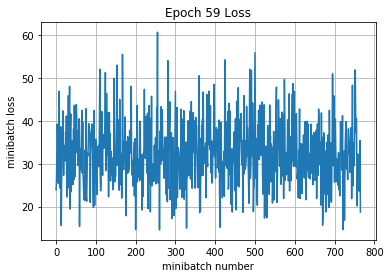

Iteration 45200: with minibatch training loss = 0.527 and accuracy of 0.83
Iteration 45300: with minibatch training loss = 0.441 and accuracy of 0.84
Iteration 45400: with minibatch training loss = 0.566 and accuracy of 0.78
Iteration 45500: with minibatch training loss = 0.44 and accuracy of 0.86
Iteration 45600: with minibatch training loss = 0.472 and accuracy of 0.81
Iteration 45700: with minibatch training loss = 0.402 and accuracy of 0.89
Iteration 45800: with minibatch training loss = 0.401 and accuracy of 0.84
Iteration 45900: with minibatch training loss = 0.681 and accuracy of 0.75
Epoch 60, Overall loss = 0.498 and accuracy of 0.83


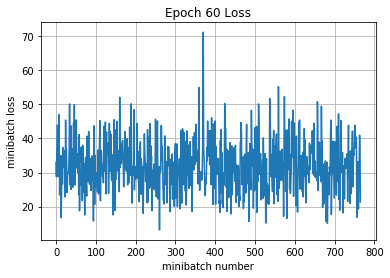

Iteration 46000: with minibatch training loss = 0.528 and accuracy of 0.8
Iteration 46100: with minibatch training loss = 0.375 and accuracy of 0.91
Iteration 46200: with minibatch training loss = 0.524 and accuracy of 0.78
Iteration 46300: with minibatch training loss = 0.554 and accuracy of 0.83
Iteration 46400: with minibatch training loss = 0.266 and accuracy of 0.91
Iteration 46500: with minibatch training loss = 0.504 and accuracy of 0.83
Iteration 46600: with minibatch training loss = 0.569 and accuracy of 0.77
Iteration 46700: with minibatch training loss = 0.582 and accuracy of 0.83
Epoch 61, Overall loss = 0.494 and accuracy of 0.832


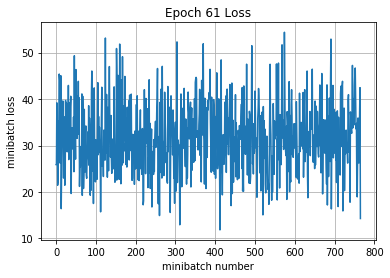

Iteration 46800: with minibatch training loss = 0.552 and accuracy of 0.8
Iteration 46900: with minibatch training loss = 0.582 and accuracy of 0.81
Iteration 47000: with minibatch training loss = 0.457 and accuracy of 0.84
Iteration 47100: with minibatch training loss = 0.505 and accuracy of 0.8
Iteration 47200: with minibatch training loss = 0.434 and accuracy of 0.83
Iteration 47300: with minibatch training loss = 0.841 and accuracy of 0.67
Iteration 47400: with minibatch training loss = 0.385 and accuracy of 0.86
Epoch 62, Overall loss = 0.483 and accuracy of 0.835


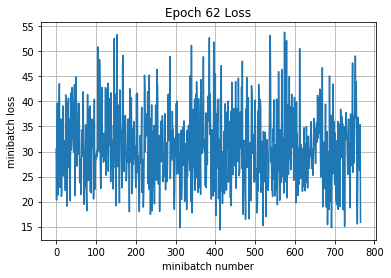

Iteration 47500: with minibatch training loss = 0.705 and accuracy of 0.77
Iteration 47600: with minibatch training loss = 0.461 and accuracy of 0.86
Iteration 47700: with minibatch training loss = 0.564 and accuracy of 0.83
Iteration 47800: with minibatch training loss = 0.551 and accuracy of 0.81
Iteration 47900: with minibatch training loss = 0.428 and accuracy of 0.86
Iteration 48000: with minibatch training loss = 0.405 and accuracy of 0.89
Iteration 48100: with minibatch training loss = 0.374 and accuracy of 0.84
Iteration 48200: with minibatch training loss = 0.438 and accuracy of 0.83
Epoch 63, Overall loss = 0.482 and accuracy of 0.835


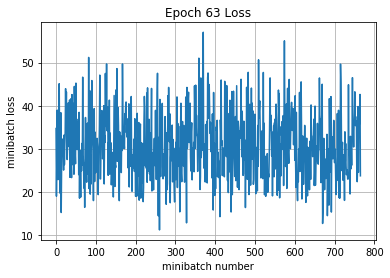

Iteration 48300: with minibatch training loss = 0.483 and accuracy of 0.8
Iteration 48400: with minibatch training loss = 0.547 and accuracy of 0.84
Iteration 48500: with minibatch training loss = 0.416 and accuracy of 0.84
Iteration 48600: with minibatch training loss = 0.276 and accuracy of 0.94
Iteration 48700: with minibatch training loss = 0.54 and accuracy of 0.8
Iteration 48800: with minibatch training loss = 0.45 and accuracy of 0.88
Iteration 48900: with minibatch training loss = 0.444 and accuracy of 0.83
Iteration 49000: with minibatch training loss = 0.339 and accuracy of 0.86
Epoch 64, Overall loss = 0.476 and accuracy of 0.835


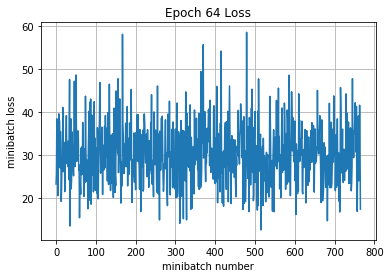

Iteration 49100: with minibatch training loss = 0.408 and accuracy of 0.86
Iteration 49200: with minibatch training loss = 0.453 and accuracy of 0.86
Iteration 49300: with minibatch training loss = 0.483 and accuracy of 0.86
Iteration 49400: with minibatch training loss = 0.53 and accuracy of 0.83
Iteration 49500: with minibatch training loss = 0.296 and accuracy of 0.88
Iteration 49600: with minibatch training loss = 0.352 and accuracy of 0.88
Iteration 49700: with minibatch training loss = 0.359 and accuracy of 0.89
Epoch 65, Overall loss = 0.468 and accuracy of 0.839


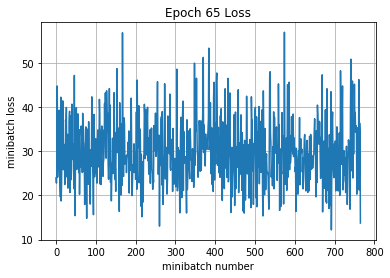

Iteration 49800: with minibatch training loss = 0.343 and accuracy of 0.88
Iteration 49900: with minibatch training loss = 0.64 and accuracy of 0.78
Iteration 50000: with minibatch training loss = 0.4 and accuracy of 0.88
Iteration 50100: with minibatch training loss = 0.546 and accuracy of 0.89
Iteration 50200: with minibatch training loss = 0.467 and accuracy of 0.78
Iteration 50300: with minibatch training loss = 0.6 and accuracy of 0.78
Iteration 50400: with minibatch training loss = 0.437 and accuracy of 0.78
Iteration 50500: with minibatch training loss = 0.544 and accuracy of 0.83
Epoch 66, Overall loss = 0.459 and accuracy of 0.843


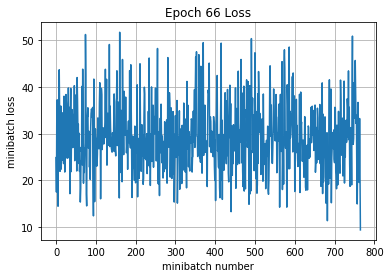

Iteration 50600: with minibatch training loss = 0.613 and accuracy of 0.8
Iteration 50700: with minibatch training loss = 0.393 and accuracy of 0.83
Iteration 50800: with minibatch training loss = 0.503 and accuracy of 0.83
Iteration 50900: with minibatch training loss = 0.559 and accuracy of 0.77
Iteration 51000: with minibatch training loss = 0.494 and accuracy of 0.86
Iteration 51100: with minibatch training loss = 0.438 and accuracy of 0.89
Iteration 51200: with minibatch training loss = 0.45 and accuracy of 0.86
Iteration 51300: with minibatch training loss = 0.564 and accuracy of 0.8
Epoch 67, Overall loss = 0.459 and accuracy of 0.843


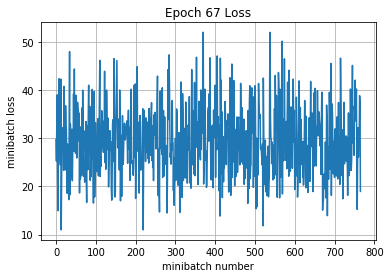

Iteration 51400: with minibatch training loss = 0.576 and accuracy of 0.78
Iteration 51500: with minibatch training loss = 0.473 and accuracy of 0.81
Iteration 51600: with minibatch training loss = 0.456 and accuracy of 0.86
Iteration 51700: with minibatch training loss = 0.41 and accuracy of 0.86
Iteration 51800: with minibatch training loss = 0.458 and accuracy of 0.8
Iteration 51900: with minibatch training loss = 0.444 and accuracy of 0.83
Iteration 52000: with minibatch training loss = 0.245 and accuracy of 0.94
Epoch 68, Overall loss = 0.451 and accuracy of 0.844


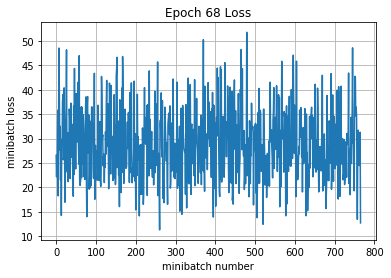

Iteration 52100: with minibatch training loss = 0.576 and accuracy of 0.84
Iteration 52200: with minibatch training loss = 0.337 and accuracy of 0.89
Iteration 52300: with minibatch training loss = 0.496 and accuracy of 0.81
Iteration 52400: with minibatch training loss = 0.366 and accuracy of 0.84
Iteration 52500: with minibatch training loss = 0.196 and accuracy of 0.92
Iteration 52600: with minibatch training loss = 0.62 and accuracy of 0.8
Iteration 52700: with minibatch training loss = 0.536 and accuracy of 0.81
Iteration 52800: with minibatch training loss = 0.42 and accuracy of 0.83
Epoch 69, Overall loss = 0.449 and accuracy of 0.845


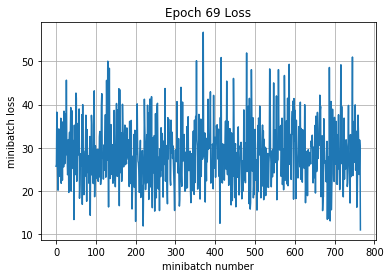

Iteration 52900: with minibatch training loss = 0.7 and accuracy of 0.8
Iteration 53000: with minibatch training loss = 0.702 and accuracy of 0.8
Iteration 53100: with minibatch training loss = 0.386 and accuracy of 0.91
Iteration 53200: with minibatch training loss = 0.361 and accuracy of 0.89
Iteration 53300: with minibatch training loss = 0.428 and accuracy of 0.84
Iteration 53400: with minibatch training loss = 0.425 and accuracy of 0.86
Iteration 53500: with minibatch training loss = 0.45 and accuracy of 0.83
Iteration 53600: with minibatch training loss = 0.31 and accuracy of 0.89
Epoch 70, Overall loss = 0.441 and accuracy of 0.849


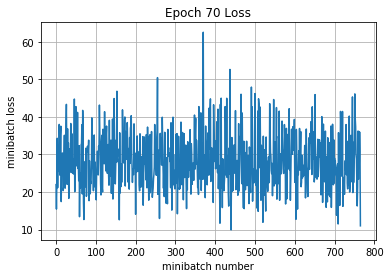

Iteration 53700: with minibatch training loss = 0.461 and accuracy of 0.81
Iteration 53800: with minibatch training loss = 0.497 and accuracy of 0.8
Iteration 53900: with minibatch training loss = 0.372 and accuracy of 0.84
Iteration 54000: with minibatch training loss = 0.396 and accuracy of 0.88
Iteration 54100: with minibatch training loss = 0.432 and accuracy of 0.86
Iteration 54200: with minibatch training loss = 0.315 and accuracy of 0.86
Iteration 54300: with minibatch training loss = 0.386 and accuracy of 0.88
Epoch 71, Overall loss = 0.44 and accuracy of 0.848


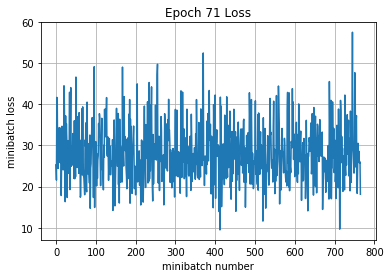

Iteration 54400: with minibatch training loss = 0.365 and accuracy of 0.86
Iteration 54500: with minibatch training loss = 0.416 and accuracy of 0.86
Iteration 54600: with minibatch training loss = 0.41 and accuracy of 0.84
Iteration 54700: with minibatch training loss = 0.491 and accuracy of 0.84
Iteration 54800: with minibatch training loss = 0.629 and accuracy of 0.8
Iteration 54900: with minibatch training loss = 0.548 and accuracy of 0.81
Iteration 55000: with minibatch training loss = 0.54 and accuracy of 0.8
Iteration 55100: with minibatch training loss = 0.357 and accuracy of 0.86
Epoch 72, Overall loss = 0.429 and accuracy of 0.853


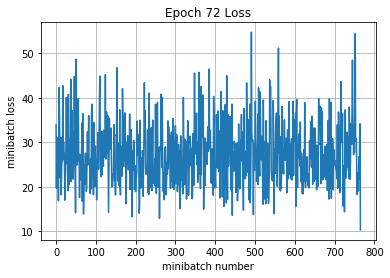

Iteration 55200: with minibatch training loss = 0.459 and accuracy of 0.88
Iteration 55300: with minibatch training loss = 0.321 and accuracy of 0.86
Iteration 55400: with minibatch training loss = 0.466 and accuracy of 0.81
Iteration 55500: with minibatch training loss = 0.586 and accuracy of 0.81
Iteration 55600: with minibatch training loss = 0.537 and accuracy of 0.83
Iteration 55700: with minibatch training loss = 0.432 and accuracy of 0.83
Iteration 55800: with minibatch training loss = 0.423 and accuracy of 0.86
Iteration 55900: with minibatch training loss = 0.393 and accuracy of 0.91
Epoch 73, Overall loss = 0.43 and accuracy of 0.854


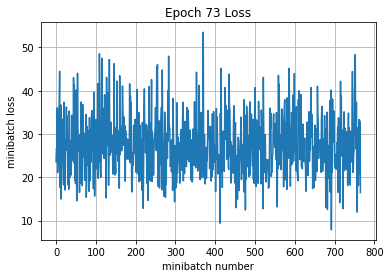

Iteration 56000: with minibatch training loss = 0.499 and accuracy of 0.86
Iteration 56100: with minibatch training loss = 0.371 and accuracy of 0.86
Iteration 56200: with minibatch training loss = 0.339 and accuracy of 0.86
Iteration 56300: with minibatch training loss = 0.45 and accuracy of 0.86
Iteration 56400: with minibatch training loss = 0.48 and accuracy of 0.84
Iteration 56500: with minibatch training loss = 0.494 and accuracy of 0.86
Iteration 56600: with minibatch training loss = 0.24 and accuracy of 0.92
Epoch 74, Overall loss = 0.423 and accuracy of 0.857


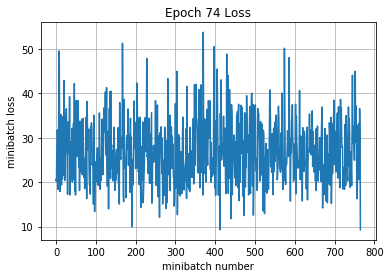

Iteration 56700: with minibatch training loss = 0.269 and accuracy of 0.95
Iteration 56800: with minibatch training loss = 0.406 and accuracy of 0.86
Iteration 56900: with minibatch training loss = 0.308 and accuracy of 0.92
Iteration 57000: with minibatch training loss = 0.304 and accuracy of 0.88
Iteration 57100: with minibatch training loss = 0.294 and accuracy of 0.89
Iteration 57200: with minibatch training loss = 0.445 and accuracy of 0.86
Iteration 57300: with minibatch training loss = 0.437 and accuracy of 0.89
Iteration 57400: with minibatch training loss = 0.748 and accuracy of 0.77
Epoch 75, Overall loss = 0.417 and accuracy of 0.856


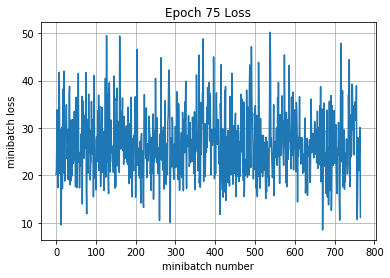

Iteration 57500: with minibatch training loss = 0.581 and accuracy of 0.8
Iteration 57600: with minibatch training loss = 0.333 and accuracy of 0.92
Iteration 57700: with minibatch training loss = 0.507 and accuracy of 0.88
Iteration 57800: with minibatch training loss = 0.511 and accuracy of 0.77
Iteration 57900: with minibatch training loss = 0.329 and accuracy of 0.91
Iteration 58000: with minibatch training loss = 0.458 and accuracy of 0.81
Iteration 58100: with minibatch training loss = 0.39 and accuracy of 0.81
Iteration 58200: with minibatch training loss = 0.501 and accuracy of 0.86
Epoch 76, Overall loss = 0.416 and accuracy of 0.857


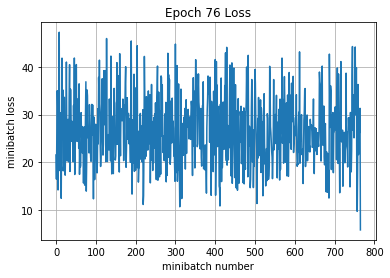

Iteration 58300: with minibatch training loss = 0.514 and accuracy of 0.8
Iteration 58400: with minibatch training loss = 0.305 and accuracy of 0.91
Iteration 58500: with minibatch training loss = 0.375 and accuracy of 0.88
Iteration 58600: with minibatch training loss = 0.507 and accuracy of 0.8
Iteration 58700: with minibatch training loss = 0.437 and accuracy of 0.88
Iteration 58800: with minibatch training loss = 0.573 and accuracy of 0.83
Iteration 58900: with minibatch training loss = 0.425 and accuracy of 0.86
Epoch 77, Overall loss = 0.411 and accuracy of 0.86


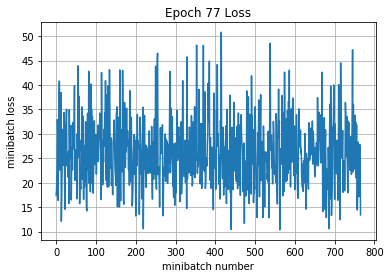

Iteration 59000: with minibatch training loss = 0.354 and accuracy of 0.88
Iteration 59100: with minibatch training loss = 0.43 and accuracy of 0.89
Iteration 59200: with minibatch training loss = 0.482 and accuracy of 0.8
Iteration 59300: with minibatch training loss = 0.527 and accuracy of 0.78
Iteration 59400: with minibatch training loss = 0.246 and accuracy of 0.94
Iteration 59500: with minibatch training loss = 0.441 and accuracy of 0.78
Iteration 59600: with minibatch training loss = 0.369 and accuracy of 0.81
Iteration 59700: with minibatch training loss = 0.378 and accuracy of 0.89
Epoch 78, Overall loss = 0.409 and accuracy of 0.86


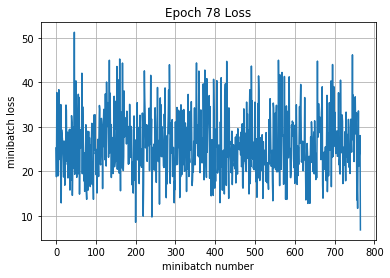

Iteration 59800: with minibatch training loss = 0.327 and accuracy of 0.86
Iteration 59900: with minibatch training loss = 0.505 and accuracy of 0.83
Iteration 60000: with minibatch training loss = 0.282 and accuracy of 0.91
Iteration 60100: with minibatch training loss = 0.425 and accuracy of 0.86
Iteration 60200: with minibatch training loss = 0.3 and accuracy of 0.91
Iteration 60300: with minibatch training loss = 0.344 and accuracy of 0.88
Iteration 60400: with minibatch training loss = 0.362 and accuracy of 0.88
Iteration 60500: with minibatch training loss = 0.521 and accuracy of 0.86
Epoch 79, Overall loss = 0.399 and accuracy of 0.864


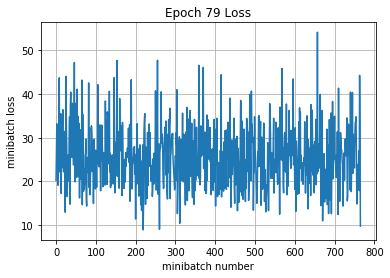

Iteration 60600: with minibatch training loss = 0.233 and accuracy of 0.92
Iteration 60700: with minibatch training loss = 0.248 and accuracy of 0.92
Iteration 60800: with minibatch training loss = 0.468 and accuracy of 0.86
Iteration 60900: with minibatch training loss = 0.365 and accuracy of 0.88
Iteration 61000: with minibatch training loss = 0.496 and accuracy of 0.83
Iteration 61100: with minibatch training loss = 0.663 and accuracy of 0.83
Iteration 61200: with minibatch training loss = 0.253 and accuracy of 0.91
Epoch 80, Overall loss = 0.394 and accuracy of 0.864


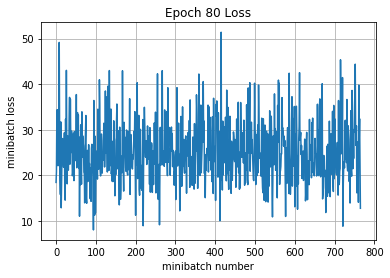

Validation
Epoch 1, Overall loss = 0.535 and accuracy of 0.827


(0.53479969549179074, 0.827)

In [18]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,80,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [19]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.241 and accuracy of 0.917
Validation
Epoch 1, Overall loss = 0.535 and accuracy of 0.827


(0.53479970264434817, 0.827)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_
conv - bn - conv - bn - max_pool - dropout - conv - bn - conv - bn - max_pool - dropout  - 5 residual_blockd - fc - bn - fc -bn - fc

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [20]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 0.593 and accuracy of 0.817


(0.59347304010391233, 0.8172)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

I used xavier initializer.